In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA 
import pmdarima as pm 
from datetime import datetime
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

##  Lire les données

In [2]:
data = pd.read_csv("2021_2022.csv",index_col=1)
data.index=pd.to_datetime(data.index,format="%d/%m/%Y %H:%M:%S")
##Filtrer les données avec Source de 4
data1=data[data['Source'] == 4]
data1.head()

,Unnamed: 0,Valeur,Source
Date,,,
2021-01-01 00:00:00,3099180,2.107,4
2021-01-01 01:00:00,3099254,3.003,4
2021-01-01 02:00:00,3099327,4.256,4
2021-01-01 03:00:00,3099400,5.529,4
2021-01-01 04:00:00,3099473,6.476,4


## Test de bruit blanc pour les données

In [3]:
print(acorr_ljungbox(data1["Valeur"], lags=1)) 
##p-value<0.05，Il s'agit d'un bruit non blanc

       lb_stat  lb_pvalue
1  9930.164347        0.0


## Diagramme temporel des données brutes

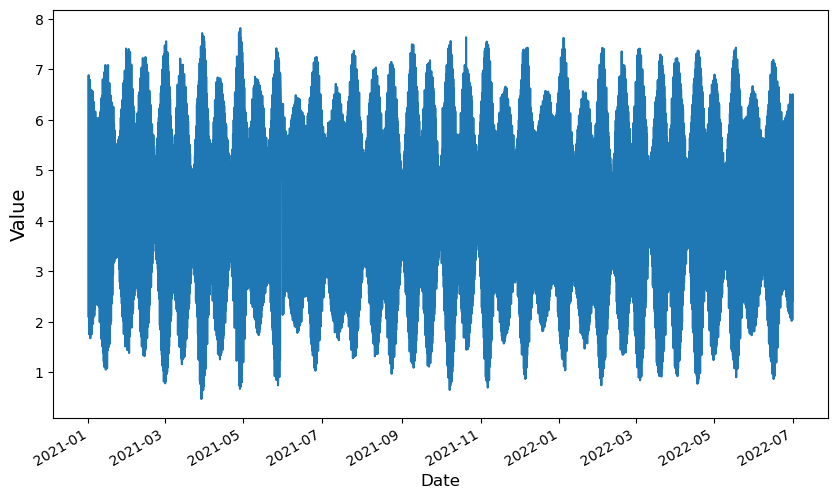

In [4]:
plt.figure(figsize = (10,6))
plt.xlabel('Date',fontsize=12,verticalalignment='top')
plt.ylabel('Value',fontsize=14,horizontalalignment='center')
data1["Valeur"].plot()
plt.show()

## Vérification de la régularité des séries de données

In [5]:
from arch.unitroot import ADF
ADF(data1["Valeur"])

##p-value=0.000, Il s'agit donc d'une série régulière

Test Statistic,-8.454
P-value,0.000
Lags,41


## Dessiner les diagrammes ACF et PACF

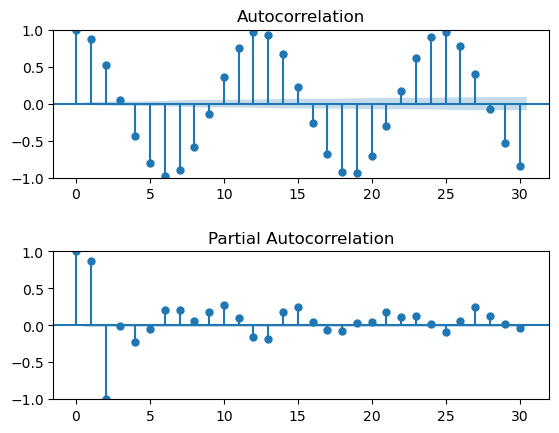

In [6]:
def draw_acf_pacf(ts,lags):

    f = plt.figure(facecolor='white')

    ax1 = f.add_subplot(211)

    plot_acf(ts,ax=ax1,lags=lags)

    ax2 = f.add_subplot(212)

    plot_pacf(ts,ax=ax2,lags=lags)

    plt.subplots_adjust(hspace=0.5)

    plt.show()

draw_acf_pacf(data1["Valeur"],30)

In [7]:
##Diviser les ensembles de test et d'apprentissage
train = data1.iloc[0:12293]
valid = data1.iloc[12293:len(data1)]
valid.head()

,Unnamed: 0,Valeur,Source
Date,,,
2022-06-01 00:00:00,3982130,2.124,4
2022-06-01 01:00:00,3982203,3.047,4
2022-06-01 02:00:00,3982276,4.254,4
2022-06-01 03:00:00,3982349,5.398,4
2022-06-01 04:00:00,3982422,6.171,4


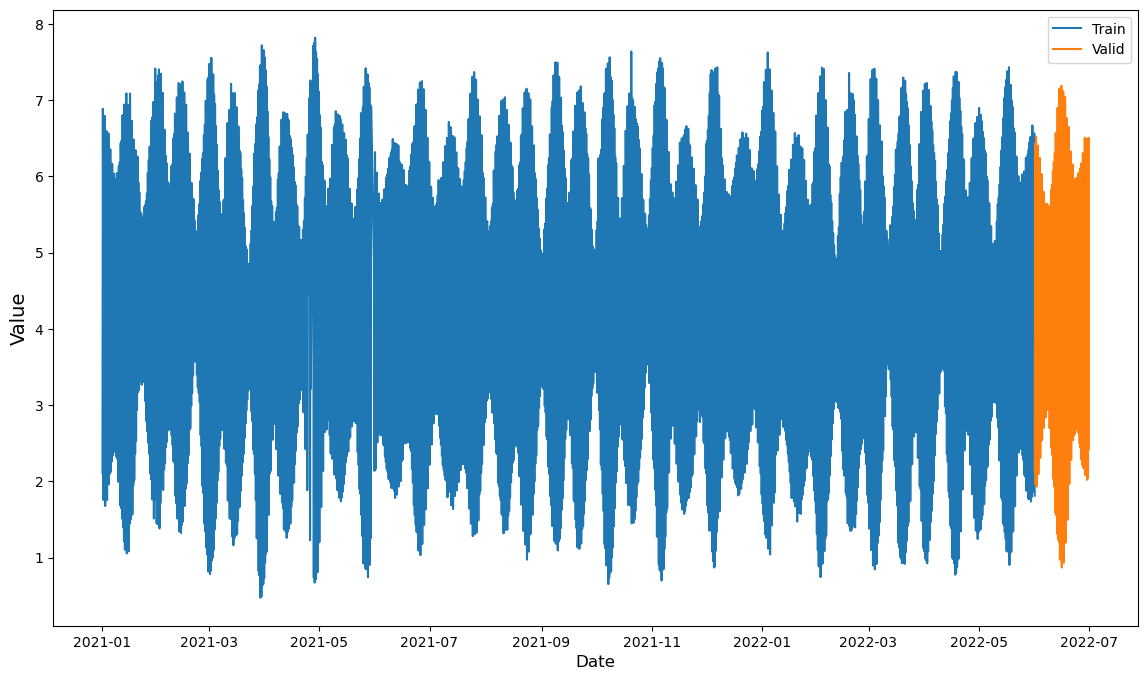

In [8]:
plt.figure(figsize = (14,8))
plt.plot(train["Valeur"],label='Train')
plt.plot(valid["Valeur"],label='Valid')
plt.xlabel('Date',fontsize=12,verticalalignment='top')
plt.ylabel('Value',fontsize=14,horizontalalignment='center')
plt.legend()
plt.show()

## ARIMA Déterminer pdq

In [9]:
##?pm.auto_arima

In [10]:
model=pm.auto_arima(train["Valeur"],trace=True,stationary=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-22369.046, Time=18.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46109.865, Time=0.68 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28408.364, Time=1.68 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=30276.031, Time=6.95 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=71818.131, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4255.365, Time=22.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-21930.407, Time=27.47 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-22367.724, Time=40.63 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-22350.054, Time=31.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=13882.088, Time=18.55 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2490.127, Time=27.30 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-22020.049, Time=46.81 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-23435.661, Time=52.50 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-23544.738, Time=68.74 sec
 AR

ARIMA(order=(2, 0, 5), scoring_args={}, suppress_warnings=True)

Sur la base du principe de l'AIC minimum, notre meilleur modèle pour l'ordre est ARIMA (ordre=(2, 0, 5)).

In [15]:
##Obtenir le modèle
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                12293
Model:               SARIMAX(2, 0, 5)   Log Likelihood               12043.914
Date:                Sat, 18 Mar 2023   AIC                         -24069.828
Time:                        15:56:23   BIC                         -24003.077
Sample:                             0   HQIC                        -24047.463
                              - 12293                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0623      0.002    542.579      0.000       1.058       1.066
ar.L1          1.7444      0.001   2150.763      0.000       1.743       1.746
ar.L2         -0.9971      0.001  -1217.812      0.000      -0.999      -0.995
ma.L1         -0.0552      0.001    -51.264      0.000      -0.057      -0.053
ma.L2         -0.2175      0.002   -133.558      0.000      -0.221      -0.214
ma.L3         -0.0295      0.003     -9.144      0.000      -0.036      -0.023
ma.L4          0.2414      0.002    129.045      0.000       0.238       0.245
ma.L5          0.2357      0.002    106.717      0.000       0.231       0.240
sigma2         0.0082      1e-05    822.514      0.000       0.008       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         376442202.86
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            13.42
Prob(H) (two-sided):                  0.00   Kurtosis:                       859.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prévision à l'aide du meilleur PDQ ARIMA

In [29]:
forecast = model.predict(n_periods=len(valid))
forecast.index = valid.index
forecast.columns=['Prediction']
forecast.head()

Date
2022-06-01 00:00:00    2.088788
2022-06-01 01:00:00    2.953329
2022-06-01 02:00:00    4.136009
2022-06-01 03:00:00    5.292730
2022-06-01 04:00:00    6.143964
dtype: float64

## Visualisation des données

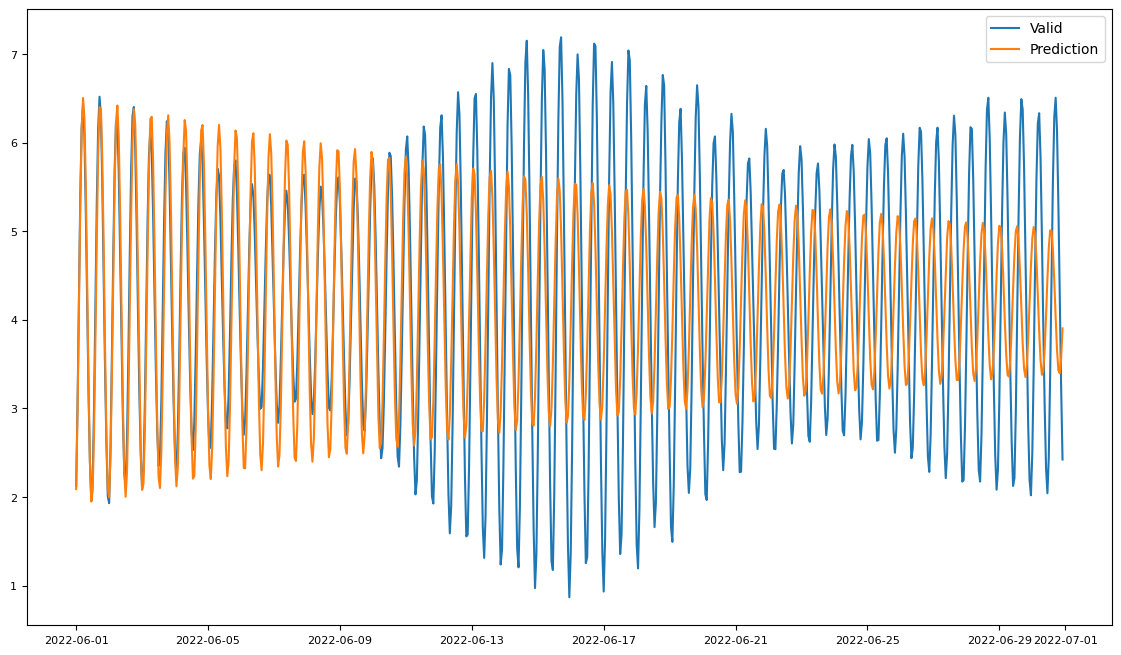

In [30]:
fig=plt.figure(figsize = (14,8))
ax1=fig.add_subplot(1,1,1) 
#plt.plot(train['Valeur'], label='Train')
plt.plot(valid['Valeur'], label='Valid')
plt.plot(forecast, label='Prediction')
plt.tick_params(axis='both',which='major',labelsize=8)
plt.legend()
plt.show()

## Calcul des erreurs

In [31]:
MSE = np.mean(np.square(valid["Valeur"].values - forecast.values))
RMSE = np.sqrt(np.mean(np.square(valid["Valeur"].values - forecast.values)))
MAE = np.mean(np.abs(valid["Valeur"].values - forecast.values))
MAPE = np.mean(np.abs((valid["Valeur"].values - forecast.values) / valid["Valeur"].values)) * 100

In [32]:
print (MSE,RMSE,MAE,MAPE)

1.568518682109577 1.2524051589280432 1.005011901056326 30.285335568960686


## Test résiduel
p-value is 0.20178705>0.05,suggérant que les résidus sont des bruits blancs et que le modèle extrait suffisamment d'informations

In [33]:
from statsmodels.stats.diagnostic import acorr_ljungbox
resid = model.resid()
print(acorr_ljungbox(resid, lags=1)) 

    lb_stat  lb_pvalue
1  1.629398   0.201786
